In [1]:
import sys
from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import natsort as ns
import re
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
from torch.utils.data import Dataset
import nibabel as nib
from sklearn.model_selection import train_test_split

# For testing only
from albumentations import Compose, Normalize, Resize, BboxParams
from omegaconf import OmegaConf
# from fitter import Fitter

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

testing_label_relative = 'VALDO_Dataset\Task2'
current_directory = os.getcwd()

two_directories_up = os.path.abspath(os.path.join(current_directory, "../"))

# Combine the current directory with the relative path
testing_label_absolute = os.path.join(two_directories_up, testing_label_relative)

folders = [item for item in os.listdir(testing_label_absolute) if os.path.isdir(os.path.join(testing_label_absolute, item))]

cases = {"cohort1": [], "cohort2": [], "cohort3": []}
# Print the list of folders
for folder in folders:
    if "sub-1" in folder:
        cases["cohort1"].append(folder)
    elif "sub-2" in folder:
        cases["cohort2"].append(folder)
    else:
        cases["cohort3"].append(folder)


<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\3141018911.py:3: SyntaxWarning: invalid escape sequence '\T'
  testing_label_relative = 'VALDO_Dataset\Task2'


In [3]:
cohort1_labels = []
cohort1_ids = []
for case in cases["cohort1"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort1_labels.append(label)
    cohort1_ids.append(id)
# print("Label:", cohort1_labels, cohort1_labels.__len__())
# print("Ids:", cohort1_ids, cohort1_ids.__len__())

cohort2_labels = []
cohort2_ids = []
for case in cases["cohort2"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort2_labels.append(label)
    cohort2_ids.append(id)
# print("Label:", cohort2_labels, cohort2_labels.__len__())
# print("Ids:", cohort2_ids, cohort2_ids.__len__())

cohort3_labels = []
cohort3_ids = []
for case in cases["cohort3"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort3_labels.append(label)
    cohort3_ids.append(id)
# print("Label:", cohort3_labels, cohort3_labels.__len__())
# print("Ids:", cohort3_ids, cohort3_ids.__len__())

all_labels = cohort1_labels + cohort2_labels + cohort3_labels
all_ids = cohort1_ids + cohort2_ids + cohort3_ids



# print(all_labels[0])
# print(all_ids[0])

In [4]:
class VALDODataset(Dataset):
    def __init__(self, img_paths, ann_paths, transform=None):
        self.img_paths = img_paths
        self.ann_paths = ann_paths
        self.transform = transform
        self.cmb_counts = self.count_cmb_per_image(self.ann_paths)

        assert len(self.img_paths) == len(
            self.ann_paths), "Mismatch between number of images and annotations"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            ann_path = self.ann_paths[idx]
            cmb_count = self.cmb_counts[idx]

            # Load 3D image
            img = nib.load(img_path).get_fdata()
            img = (img / np.max(img) * 255).astype(np.uint8)

            # Load 3D annotation
            ann = nib.load(ann_path).get_fdata()
            ann = (ann > 0).astype(np.uint8)  # Ensure mask is binary

            slices = []
            targets = []

            for i in range(img.shape[2]):
                img_slice = img[:, :, i]
                ann_slice = ann[:, :, i]

                # Convert single-channel to three-channel
                img_slice = cv2.merge([img_slice] * 3)
                boxes = self.extract_bounding_boxes(ann_slice)

                if boxes:
                    augmented = self.transform(
                        image=img_slice, bboxes=boxes, labels=[1]*len(boxes))
                    img_slice = augmented['image']
                    boxes = augmented['bboxes']
                    labels = augmented['labels']
                else:
                    augmented = self.transform(
                        image=img_slice, bboxes=[], labels=[])
                    img_slice = augmented['image']
                    boxes = augmented['bboxes']
                    labels = augmented['labels']

                target = {
                    'boxes': torch.tensor(boxes, dtype=torch.float32),
                    'labels': torch.tensor(labels, dtype=torch.int64)
                }

                slices.append(img_slice)
                targets.append(target)

            return slices, targets, img_path, cmb_count

        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x + w, y + h])
            # boxes.append([x-8.5, y-8.5, x + 20, y + 20])
            # boxes.append([x, y, w, h])
        return boxes

    def count_cmb_per_image(self, segmented_images):
        cmb_counts = []
        for img_path in segmented_images:
            img = nib.load(img_path)
            data = img.get_fdata()
            slice_cmb_counts = [self.extract_bounding_boxes(
                (data[:, :, i] > 0).astype(np.uint8)) for i in range(data.shape[2])]
            total_cmb_count = sum(len(contours)
                                  for contours in slice_cmb_counts)
            cmb_counts.append(total_cmb_count)
        return cmb_counts

In [5]:
transform = Compose(
        [
            A.Resize(height=256, width=256, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
)

In [6]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

def collate_fn(batch):
    slices = []
    targets = []
    img_paths = []
    cmb_counts = []

    for item in batch:
        item_slices, item_targets, item_img_path, item_cmb_counts = item
        slices.extend(item_slices)
        targets.extend(item_targets)
        img_paths.append(item_img_path)
        cmb_counts.append(item_cmb_counts)

    slices = [torch.stack(tuple(slice_set)) for slice_set in slices]

    return slices, targets, img_paths,
    
def euclid_dist(t1, t2):
    t1 = np.array(t1)
    t2 = np.array(t2)
    return np.sqrt(((t1-t2)**2).sum())


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    all_ids, all_labels, test_size=0.30, random_state=40)

train_dataset_aug = VALDODataset(
    img_paths=X_train, ann_paths=y_train, transform=transform
)

validation_dataset = VALDODataset(
    img_paths=X_test, ann_paths=y_test, transform=transform
)

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def get_predicted_marking_validation(dataset, prediction_list, slice_num, id, score_threshold=0.15):
    predicted_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [], 
        'w': [], 
        'h': [], 
        # 'confidence': [],
        # 'class': []
    }
    # print(prediction_list)

    for box in prediction_list:
        if box[4].item() > score_threshold:
            predicted_cmbs['image_id'].append(id)
            predicted_cmbs['slice_num'].append(slice_num)
            predicted_cmbs['x'].append(box[0].item())
            predicted_cmbs['y'].append(box[1].item())
            predicted_cmbs['w'].append(box[2].item())
            predicted_cmbs['h'].append(box[3].item())
            # predicted_cmbs['confidence'].append(box[3].item())
            # predicted_cmbs['class'].append(box[3].item())


    # Convert to DataFrame once at the end
    predicted_cmbs_df = pd.DataFrame(predicted_cmbs)
    return predicted_cmbs_df

In [10]:
def get_all_marking(dataset):
    all_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [],
        'w': [],
        'h': []
    }
    for i in range(len(dataset)):
        slices, targets, id, count = dataset[i]
        # case = pd.DataFrame(columns=['image_id', 'slice', 'x', 'y', 'w', 'h'])
        for j in range(len(slices)):
            for target in targets[j]['boxes']:
                all_cmbs['image_id'].append(id)
                all_cmbs['slice_num'].append(j)
                all_cmbs['x'].append(target[0].item())
                all_cmbs['y'].append(target[1].item())
                all_cmbs['w'].append(target[2].item())
                all_cmbs['h'].append(target[3].item())

    # Convert to DataFrame once at the end
    all_cmbs = pd.DataFrame(all_cmbs)
    return all_cmbs

In [11]:
def count_FPTP(all_marking, predicted_marking):
    # Initialize
    fp = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
    fp_count = 0
    tp = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
    tp_count = 0
    fn = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
    fn_count = 0
    
    # Merge according to image_id and slice_num
    merged_df = pd.merge(predicted_marking, all_marking, on=['image_id', 'slice_num'], suffixes=('_pred', '_true'))

    # Get the initial false positives
    # Create a key for matching
    predicted_marking['key'] = predicted_marking['image_id'] + '_' + predicted_marking['slice_num'].astype(str)
    merged_df['key'] = merged_df['image_id'] + '_' + merged_df['slice_num'].astype(str)

    # Use isin to identify rows not in merged_df
    fp = predicted_marking[~predicted_marking['key'].isin(merged_df['key'])]
    fp = fp.drop(columns=['key'])
    fp_count += len(fp)

    grouped_dict = {}

    # Group by image_id and slice_num
    grouped = merged_df.groupby(['image_id', 'slice_num'])

    # Iterate over the groups and store in the dictionary
    for (image_id, slice_num), group in grouped:
        key = (image_id, slice_num)
        grouped_dict[key] = group

    # Get all the counts
    for key, df in grouped_dict.items():
        x_pred_values = df['x_pred'].values
        y_pred_values = df['y_pred'].values
        x_true_values = df['x_true'].values
        y_true_values = df['y_true'].values

        w_pred_values = df['w_pred'].values
        h_pred_values = df['h_pred'].values

        is_correct = False
        for i in range(len(x_pred_values)):
            pred_cmb = [x_pred_values[i], y_pred_values[i]]
            true_cmb = [x_true_values[i], y_true_values[i]]
            dist = euclid_dist(pred_cmb, true_cmb)
            if dist > 20:
                is_correct = False
            else:
                is_correct = True
                break
        
        new_row = {
            'image_id': key[0],
            'slice_num': key[1],
            'x': x_pred_values[i],
            'y': y_pred_values[i],
            'w': w_pred_values[i],
            'h': h_pred_values[i]
        }
        temp = pd.DataFrame(new_row, index=[0])
        
        if is_correct:
            tp_count += 1
            tp = pd.concat([tp, temp], ignore_index=True)
        else:
            fp_count += 1
            fp = pd.concat([fp, temp], ignore_index=True)
        

    all_marking['key'] = all_marking['image_id'] + '_' + all_marking['slice_num'].astype(str)
    tp['key'] = tp['image_id'] + '_' + tp['slice_num'].astype(str)
    # Use isin to identify rows not in tp
    fn = all_marking[all_marking['key'].isin(tp['key'])]
    fn = fn.drop(columns=['key'])
    fn_count += len(fn)

    tp = tp.drop(columns=['key'])

    return fp, fp_count, tp, tp_count, fn, fn_count

In [12]:
class Fitter:

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        summary_loss_over_itr_train = []
        summary_loss_over_itr_val = []
        history = []
        all_marking = get_all_marking(validation_loader.dataset)
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, step_history = self.train_one_epoch(train_loader)
            history.append(step_history)
            summary_loss_over_itr_train.append(summary_loss)
            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, precision_ave, recall_ave = self.validation(validation_loader, all_marking)
            summary_loss_over_itr_val.append(summary_loss)
            # print(len(predictions))
            # print(predictions[0].shape)
            # print(predictions[0][0].shape)
            # # for i in range(predictions)
            # for prediction in predictions:
            #     for detection in prediction[0]:
            #         x_min, y_min, x_max, y_max, confidence, class_label = detection
            #         if confidence > 0.7:  # Filter out detections with low confidence
            #             print(f"Detected class {class_label} with confidence {confidence}")
            #             print(f"Bounding box: ({x_min}, {y_min}) to ({x_max}, {y_max})")

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}, precision: {precision_ave:.5f}, recall: {recall_ave:.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(
                    f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return self.best_summary_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history


    def validation(self, val_loader, all_marking):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        precision_list = []
        recall_list = []
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' +
                        f'summary_loss: {summary_loss.avg:.5f}, ' +
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                batch_size = len(images)
                images = torch.stack(images).to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                
                for i in range(len(images)):
                    img = images[i].unsqueeze(0)
                    bbox = boxes[i]
                    cls = labels[i]
                    
                    if bbox.nelement() == 0 or cls.nelement() == 0:
                        continue
                    
                    target = {
                        "bbox": bbox.unsqueeze(0),
                        "cls": cls.unsqueeze(0),
                        'img_scale': None,
                        'img_size': None,   
                    }

                    # loss, _, _, _ = self.model(img, target)
                    score_threshold = 0.05
                    output = self.model(img, target)
                    predicted_marking = get_predicted_marking_validation(val_loader.dataset, output['detections'][0], i, image_ids[0], score_threshold=score_threshold)
                    if len(predicted_marking) == 0:
                        continue
                    result = count_FPTP(all_marking, predicted_marking)

                    try:
                        precision = result[3]/(result[3] + result[1])
                    except ZeroDivisionError:
                        precision = 0.0

                    try:
                        recall = result[3]/(result[3] + result[5])
                    except ZeroDivisionError:
                        recall = 0.0

                    precision_list.append(precision)
                    recall_list.append(recall)
                    summary_loss.update(output["loss"].detach().item(), batch_size)

        try:            
            precision_ave = sum(precision_list) / len(precision_list)
        except ZeroDivisionError:
            precision_ave = 0.0
        try:
            recall_ave = sum(recall_list) / len(recall_list)
        except ZeroDivisionError:
            recall_ave = 0.0
        return summary_loss, precision_ave, recall_ave

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        history = []

        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            batch_size = len(images[0])
            images = [image.to(self.device).float() for image in images]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            self.optimizer.zero_grad()
                
            for i in range(len(images)):
                img = images[i].unsqueeze(0)
                bbox = boxes[i]
                cls = labels[i]

                # Check if the current slice has any bounding boxes
                if bbox.nelement() == 0 or cls.nelement() == 0:
                    continue

                target = {
                    "bbox": boxes[i].unsqueeze(0),
                    "cls": labels[i].unsqueeze(0)
                }

                output = self.model(img, target)
                output['loss'].backward()
                summary_loss.update(output['loss'].detach().item(), batch_size)

                # TODO: change with appropriate metrics
                history.append(summary_loss.avg)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()


        return summary_loss, history


    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [13]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 1
    # n_epochs = 10
    n_epochs = 10
    # lr = 0.0001
    lr = 0.01

    folder = 'Model_Save(Axial)_D7'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False # do scheduler.step after optimizer.step
    epoch_scheduler = False
    validation_scheduler = True # do scheduler.step after validation stage loss -> For scheduler 'ReduceLROnPlateau'
    
#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=2*int(len(train_dataset_aug) / batch_size),
#         pct_start=0.31,
#         anneal_strategy='cos', 
#         final_div_factor=10**4
#     )

#     SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
#     scheduler_params = dict(
#         T_0=5,        # Number of iterations for the first restart.
#         T_mult=2,    
#         eta_min=0.00004,
#         last_epoch=-1, 
#         verbose=False
#     )

#     SchedulerClass = torch.optim.lr_scheduler.ExponentialLR
#     scheduler_params = dict(
#         gamma = 0.7
#     )

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.1,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=0,
        eps=1e-08
    )

In [14]:
def get_net():

    config = get_efficientdet_config('tf_efficientdet_d7')
    config.update({'num_classes': 1})
    config.update({'image_size': (256, 256)})
    config.update({"url": "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7-f05bf714.pth"})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    # checkpoint = torch.load('efficientdet_d7-f05bf714.pth')
    # net.load_state_dict(checkpoint, strict=False)

    net.class_net = HeadNet(config, num_outputs=config.num_classes) #Use default batchnorm
    
    return DetBenchTrain(net, config)

In [15]:
dataset = VALDODataset(
    img_paths=all_ids, ann_paths=all_labels, transform=transform)

In [16]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.img_paths,
    'Segmented Masks': dataset.ann_paths,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

# df_dataset

In [17]:
train_df, val_df = train_test_split(
    df_dataset, test_size=0.2, stratify=df_dataset['Has CMB'], random_state=42)

In [18]:
train_dataset = VALDODataset(train_df['MRI Scans'].tolist(), train_df['Segmented Masks'].tolist(), transform=transform)
val_dataset = VALDODataset(val_df['MRI Scans'].tolist(), val_df['Segmented Masks'].tolist(), transform=transform)

In [19]:
def run_training():

    net = get_net()
    device = torch.device('cuda')
    print(device)
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,     
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=False,   #drop last one for having same batch size
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(val_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history = fitter.fit(train_loader, val_loader)
    
    return best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history

In [20]:
best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history = run_training()

{'name': 'tf_efficientdet_d7', 'backbone_name': 'tf_efficientnet_b6', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [256, 256], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 5.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 5, 'fpn_cell_repeats': 8, 'fpn_channels': 384, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': 'bifpn_sum', 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


cuda


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fitter prepared. Device is cuda


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()



2024-05-19T11:55:32.385367
LR: 0.01
[RESULT]: Train. Epoch: 0, summary_loss: 43.83356, time: 176.99614
[RESULT]: Val. Epoch: 0, summary_loss: 293.53459, time: 32.74648, precision: 0.00000, recall: 0.00000


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()



2024-05-19T11:59:05.867929
LR: 0.01
[RESULT]: Train. Epoch: 1, summary_loss: 1.57481, time: 170.86855


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 1, summary_loss: 9.36855, time: 29.98853, precision: 0.06667, recall: 0.03333


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()



2024-05-19T12:02:30.301172
LR: 0.01
[RESULT]: Train. Epoch: 2, summary_loss: 1.25157, time: 168.96830


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 2, summary_loss: 48.34587, time: 27.83459, precision: 0.37500, recall: 0.18750

2024-05-19T12:05:48.712454
LR: 0.01


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


[RESULT]: Train. Epoch: 3, summary_loss: 1.55661, time: 167.79444


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or a

C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 3, summary_loss: 2.18488, time: 29.00769, precision: 0.50000, recall: 0.25000


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()



2024-05-19T12:09:09.113292
LR: 0.01
[RESULT]: Train. Epoch: 4, summary_loss: 1.07814, time: 176.83759


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 4, summary_loss: 102.53160, time: 30.29067, precision: 0.66667, recall: 0.33333

2024-05-19T12:12:38.067092
LR: 0.01


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


[RESULT]: Train. Epoch: 5, summary_loss: 0.85632, time: 187.02963


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 5, summary_loss: 8.95974, time: 31.13407, precision: 0.62500, recall: 0.31250

2024-05-19T12:16:18.344448
LR: 0.001


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


[RESULT]: Train. Epoch: 6, summary_loss: 0.80462, time: 166.93954


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or a

C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 6, summary_loss: 1.07986, time: 26.99828, precision: 0.83333, recall: 0.41667


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()



2024-05-19T12:19:35.492726
LR: 0.001
[RESULT]: Train. Epoch: 7, summary_loss: 0.77938, time: 162.81100
[RESULT]: Val. Epoch: 7, summary_loss: 0.91056, time: 27.04633, precision: 0.00000, recall: 0.00000


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()



2024-05-19T12:22:48.733272
LR: 0.001
[RESULT]: Train. Epoch: 8, summary_loss: 0.77132, time: 158.79218


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 8, summary_loss: 28.67132, time: 27.12385, precision: 0.25000, recall: 0.12500

2024-05-19T12:25:56.384263
LR: 0.001


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\91189965.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


[RESULT]: Train. Epoch: 9, summary_loss: 0.77372, time: 158.20338


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


[RESULT]: Val. Epoch: 9, summary_loss: 75.87861, time: 26.63222, precision: 0.50000, recall: 0.25000


In [21]:
# len(val_predictions[0])

# val_predictions[0][0]['predictions'][0][0]

In [22]:
# print(len(val_predictions[0]))
# count = 0

# for prediction in val_predictions[0]:
#     for detection in prediction[0]:
#         # print(len(detection))
#         x_min, y_min, x_max, y_max, confidence, class_label = detection
#         confidence = confidence.item()
#         # print(confidence)
#         if confidence > 0.18:  # Filter out detections with low confidence
#             count += 1
#             print(f"Detected class {class_label} with confidence {confidence}")
#             print(f"Bounding box: ({x_min}, {y_min}) to ({x_max}, {y_max})")

In [23]:
def load_net(checkpoint_path):
    device = torch.device('cuda')
    config = get_efficientdet_config('tf_efficientdet_d7') # Not sure if gagamitin dapat yung d7
    
    config.update({'num_classes': 1})
    config.update({'image_size': (256, 256)})
    config.update({"norm_kwargs": dict(eps=.001, momentum=.01)})


    net = EfficientDet(config, pretrained_backbone=False)
    net.class_net = HeadNet(config, num_outputs=config.num_classes) # Configures the classification head of the model

    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net)
    net.eval()
    device = torch.device(device)
    return net.to(device)

Check kung anong epoch gagamitin para sa prediction

In [94]:
net_axial = load_net('Model_Save(Axial)_D7/best-checkpoint-008epoch.bin')

In [95]:
def make_predictions_axial(images, score_threshold=0.06): #Confidence score...? Default 0.22
    device = torch.device('cuda')
    images = torch.stack(images).to(device).float()
    predictions = []
    with torch.no_grad():
        # det = net_axial(images, torch.tensor([1]*images.shape[0]).float().to(device))
        det = net_axial(images)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            # print(indexes)
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    torch.cuda.empty_cache()
    return predictions

In [96]:
test_dataset_all_axial = VALDODataset(
    img_paths=cohort1_ids, ann_paths=cohort1_ids, transform=transform
)

test_data_loader_all_axial = DataLoader(
    test_dataset_all_axial,
    batch_size=1,
    drop_last=False,   #drop last one for having same batch size
    num_workers=0,
    collate_fn=collate_fn,
)

In [97]:
torch.cuda.empty_cache()

In [98]:
prediction_list = []
for j, (images_axial, targets_axial, image_ids_axial) in enumerate(test_data_loader_all_axial):
    predictions = make_predictions_axial(images_axial)
    prediction_list.append({"predictions": predictions, "id": image_ids_axial})
    print(f'Batch {j} prediction done')

Batch 0 prediction done
Batch 1 prediction done
Batch 2 prediction done
Batch 3 prediction done
Batch 4 prediction done
Batch 5 prediction done
Batch 6 prediction done
Batch 7 prediction done
Batch 8 prediction done
Batch 9 prediction done
Batch 10 prediction done


In [99]:
print(prediction_list[0]['id'])
print(prediction_list[0]['predictions'])

['c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\VALDO_Dataset\\Task2\\sub-101\\sub-101_space-T2S_desc-masked_T2S.nii.gz']
[{'boxes': array([[ 24.736122 , 248.76608  ,  60.342766 , 509.60883  ],
       [ 24.909443 , 240.55109  ,  60.60374  , 493.13843  ],
       [ 24.904272 , 232.30438  ,  60.56971  , 476.62036  ],
       [ -4.6581664, 252.39258  ,  10.798502 , 536.4609   ],
       [ 24.862617 , 224.21892  ,  60.470703 , 460.40955  ],
       [ 24.859007 , 144.30736  ,  60.44995  , 300.62466  ],
       [ 24.855162 , 152.34476  ,  60.441765 , 316.66925  ],
       [ 24.862036 , 136.2615   ,  60.456955 , 284.56512  ],
       [ 24.866184 , 216.23639  ,  60.475033 , 444.42245  ],
       [ 24.85357  , 160.3773   ,  60.43937  , 332.70856  ],
       [ 24.865023 , 128.21254  ,  60.464806 , 268.5012   ],
       [ 24.854368 , 168.39886  ,  60.44249  , 348.73102  ],
       [ 24.86797  , 120.15758  ,  60.472904 , 252.42531  ],
       [ 24.859535 , 176.41237  ,  60.45584  , 364.74503  ],
       [

In [100]:
predicted_boxes = []
temp = prediction_list[0]['predictions']
print(temp)
for i in range(len(temp)):
    print(temp[i])
    # print(i, prediction_list[0]['predictions'][i])
    predicted_boxes.append(temp[i]['boxes'])
# predicted_boxes

[{'boxes': array([[ 24.736122 , 248.76608  ,  60.342766 , 509.60883  ],
       [ 24.909443 , 240.55109  ,  60.60374  , 493.13843  ],
       [ 24.904272 , 232.30438  ,  60.56971  , 476.62036  ],
       [ -4.6581664, 252.39258  ,  10.798502 , 536.4609   ],
       [ 24.862617 , 224.21892  ,  60.470703 , 460.40955  ],
       [ 24.859007 , 144.30736  ,  60.44995  , 300.62466  ],
       [ 24.855162 , 152.34476  ,  60.441765 , 316.66925  ],
       [ 24.862036 , 136.2615   ,  60.456955 , 284.56512  ],
       [ 24.866184 , 216.23639  ,  60.475033 , 444.42245  ],
       [ 24.85357  , 160.3773   ,  60.43937  , 332.70856  ],
       [ 24.865023 , 128.21254  ,  60.464806 , 268.5012   ],
       [ 24.854368 , 168.39886  ,  60.44249  , 348.73102  ],
       [ 24.86797  , 120.15758  ,  60.472904 , 252.42531  ],
       [ 24.859535 , 176.41237  ,  60.45584  , 364.74503  ],
       [ 24.887623 , 208.29782  ,  60.520424 , 428.5316   ],
       [ 24.868301 , 184.41191  ,  60.476868 , 380.7382   ],
       [ 24.8

In [101]:
dataset = VALDODataset(img_paths=cohort1_ids, ann_paths=cohort1_labels, transform=transform)

tensor([[ 82.0000, 163.5000,  86.0000, 168.0000],
        [ 90.0000, 149.5000,  92.0000, 151.5000]])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


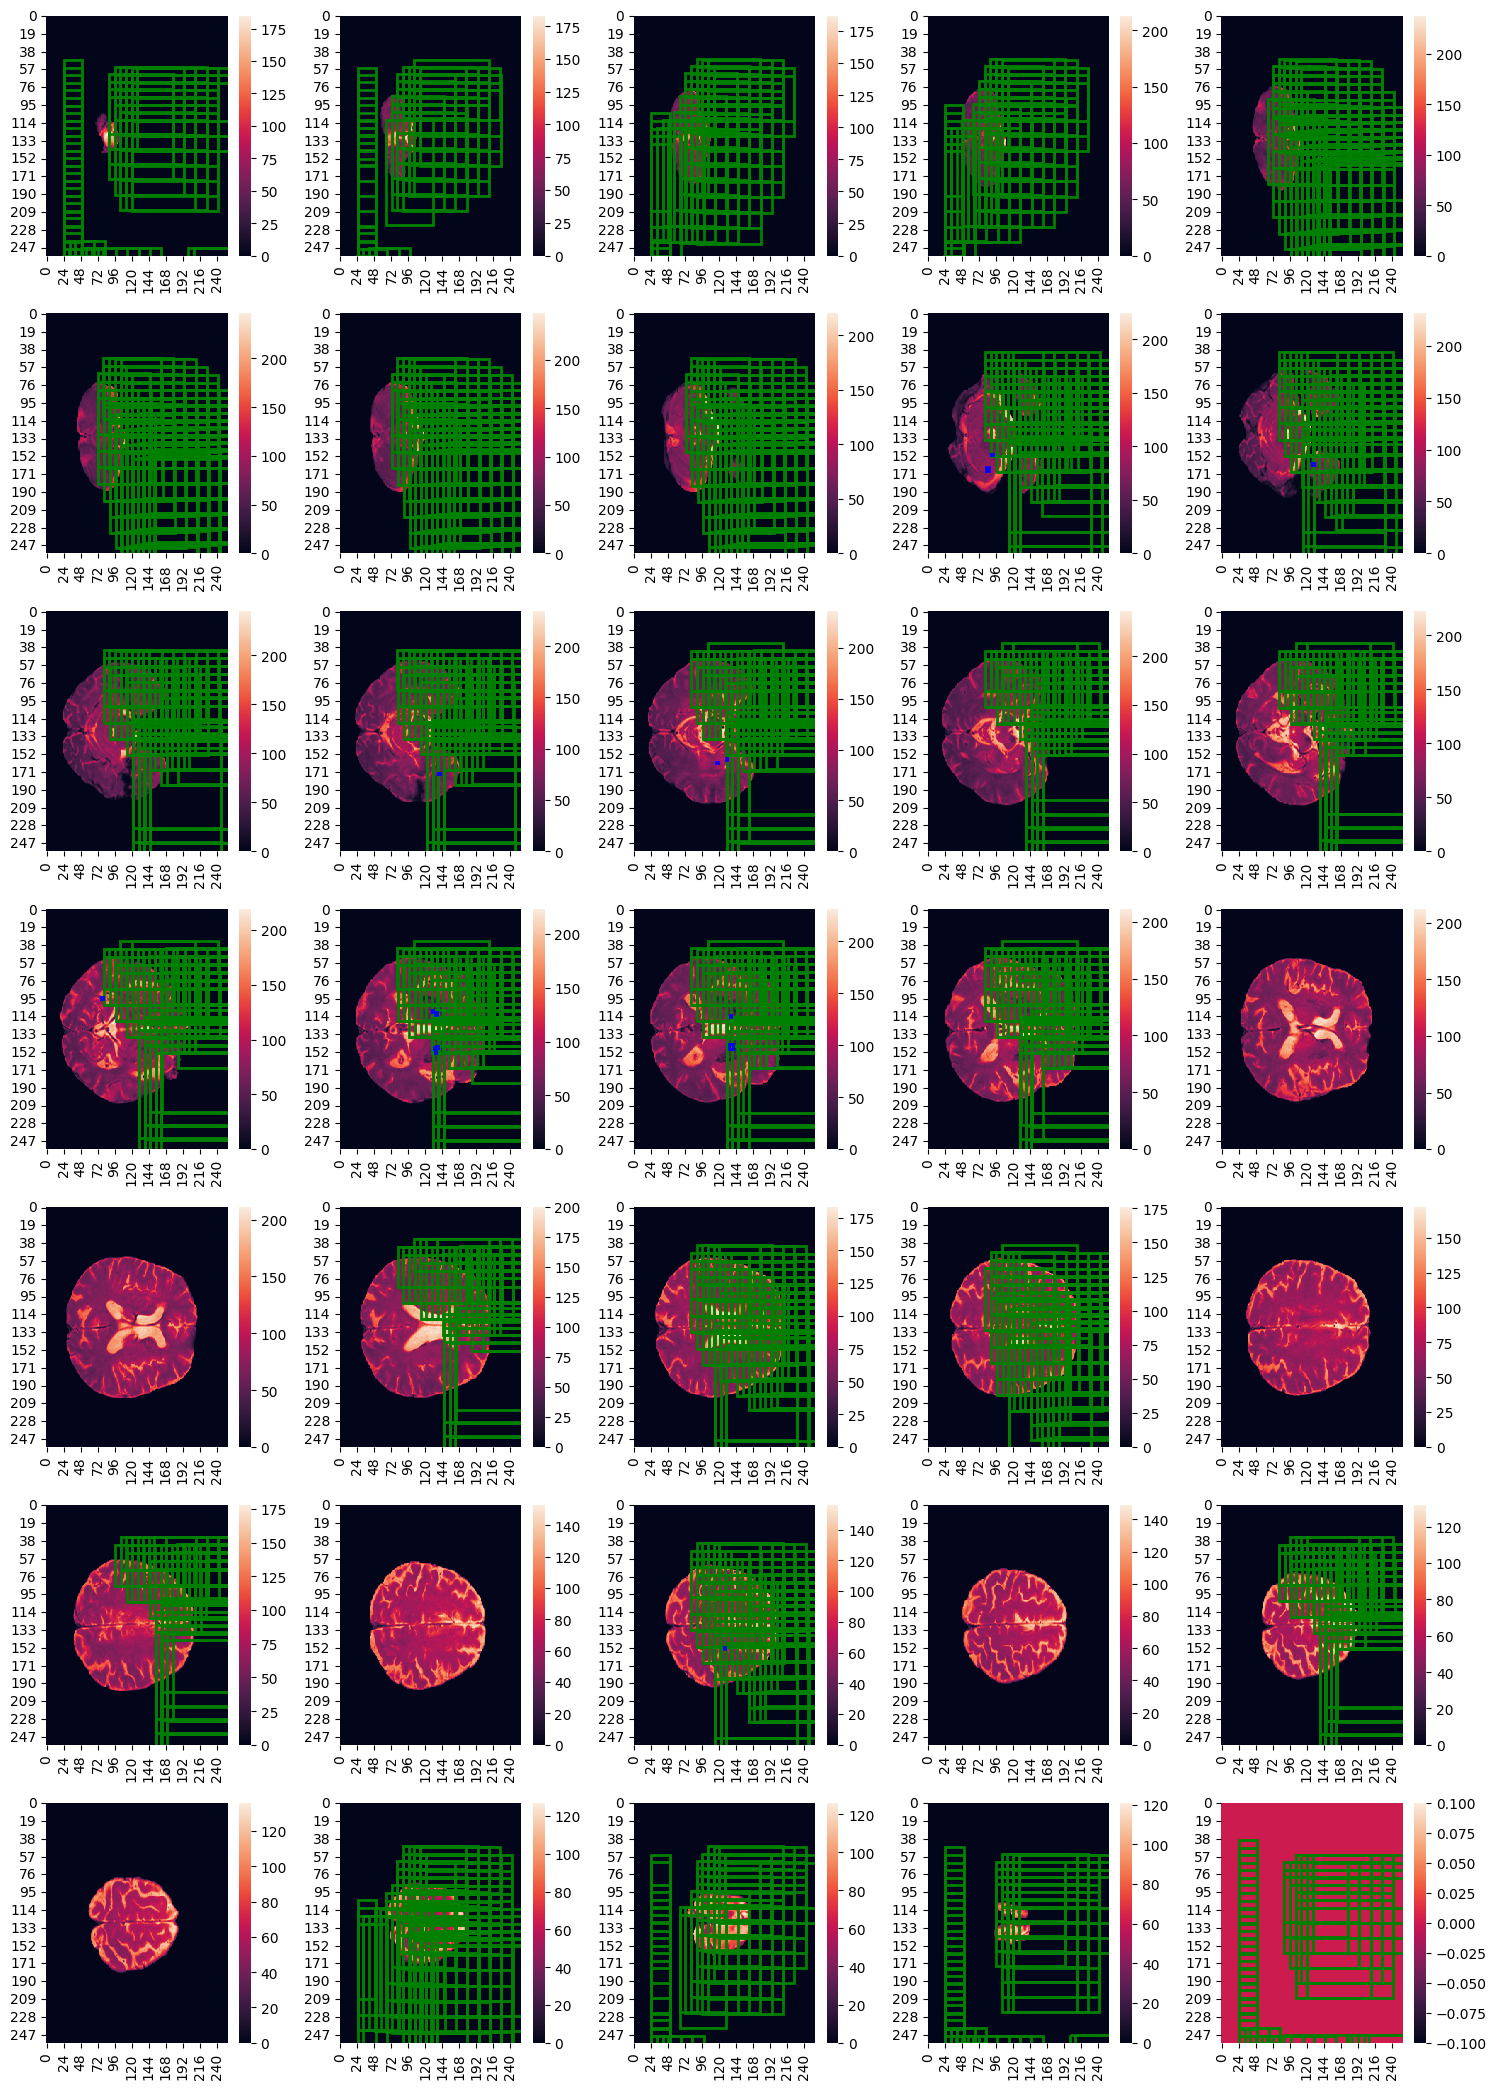

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming you have defined `targets` and `slices` elsewhere in your code
slices, targets, id, count = dataset[0]
# Calculate the number of subplots needed based on the length of your data
num_slices = len(slices)
num_cols = 5
num_rows = (num_slices + num_cols - 1) // num_cols  # Round up to the nearest integer

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
print(targets[8]['boxes'])
# Iterate over slices and targets
for idx, (slice_base, target) in enumerate(zip(slices, targets)):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    # Generate heatmap
    heatmap_data = torch.mean(slice_base.float(), dim=0)
    heatmap_data_np = heatmap_data.numpy()
    sns.heatmap(heatmap_data_np, ax=ax)

    # Generate bounding box
    print(idx)
    boxes = predicted_boxes[idx]
    for box in boxes:
        box = torch.from_numpy(box)
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_min + 1, y_min + 1, 
                                    linewidth=2, edgecolor='g', facecolor='none'))
    
    boxes = target['boxes']
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                    linewidth=2, edgecolor='b', facecolor='none'))
    

plt.tight_layout()
plt.show()

In [103]:
dataset = VALDODataset(img_paths=cohort1_ids, ann_paths=cohort1_labels, transform=transform)

In [104]:
def get_all_marking(dataset):
    all_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [],
        'w': [],
        'h': []
    }
    for i in range(len(dataset)):
        slices, targets, id, count = dataset[i]
        # case = pd.DataFrame(columns=['image_id', 'slice', 'x', 'y', 'w', 'h'])
        for j in range(len(slices)):
            for target in targets[j]['boxes']:
                all_cmbs['image_id'].append(id)
                all_cmbs['slice_num'].append(j)
                all_cmbs['x'].append(target[0].item())
                all_cmbs['y'].append(target[1].item())
                all_cmbs['w'].append(target[2].item())
                all_cmbs['h'].append(target[3].item())

    # Convert to DataFrame once at the end
    all_cmbs = pd.DataFrame(all_cmbs)
    return all_cmbs

In [105]:
def get_predicted_marking(dataset, prediction_list):
    predicted_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [], 
        'w': [], 
        'h': []
    }

    for i in range(len(dataset)):
        slices, _, id, count = dataset[i]
        predictions = prediction_list[i]['predictions']
        for j in range(len(slices)):
            for k in range(len(predictions[j]['boxes'])):
                box = predictions[j]['boxes'][k]
                x_min, y_min, w, h = box
                predicted_cmbs['image_id'].append(id)
                predicted_cmbs['slice_num'].append(j)
                predicted_cmbs['x'].append(x_min)
                predicted_cmbs['y'].append(y_min)
                predicted_cmbs['w'].append(w)
                predicted_cmbs['h'].append(h)

    # Convert to DataFrame once at the end
    predicted_cmbs_df = pd.DataFrame(predicted_cmbs)
    return predicted_cmbs_df

In [106]:
all_marking = get_all_marking(dataset)
predicted_marking = get_predicted_marking(dataset, prediction_list)

In [107]:
result = count_FPTP(all_marking, predicted_marking)

C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_30680\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


In [108]:
print(result[2]['image_id'])

0     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
1     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
2     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
3     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
4     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
5     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
6     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
7     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
8     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
9     c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
10    c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
Name: image_id, dtype: object


In [109]:
try:
    precision = result[3]/(result[3] + result[1])
except ZeroDivisionError:
    precision = 0.0

try:
    recall = result[3]/(result[3] + result[5])
except ZeroDivisionError:
    recall = 0.0
print('precision:', precision)
print('recall:', recall)

precision: 0.0004700653818212897
recall: 0.275


In [110]:
print("Predicted Marking DataFrame dtypes:")
print(predicted_marking.dtypes)

print("\nAll Marking DataFrame dtypes:")
print(all_marking.dtypes)

Predicted Marking DataFrame dtypes:
image_id      object
slice_num      int64
x            float32
y            float32
w            float32
h            float32
key           object
dtype: object

All Marking DataFrame dtypes:
image_id      object
slice_num      int64
x            float64
y            float64
w            float64
h            float64
key           object
dtype: object


In [111]:
all_marking

,image_id,slice_num,x,y,w,h,key
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,128.5,160.0,130.0,162.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,139.0,172.5,140.5,174.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,116.5,160.5,118.5,162.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
...,...,...,...,...,...,...,...
149,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,131.5,169.0,133.5,171.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
150,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,18,139.5,88.5,143.5,92.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
151,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,19,178.0,105.5,180.5,108.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
152,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,19,139.5,88.0,144.0,93.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...


In [112]:
# num=6
# print(predicted_marking['image_id'][num])
# print(merged_df['image_id'][num])

In [113]:
merged_df = pd.merge(predicted_marking, all_marking, on=['image_id', 'slice_num'], suffixes=('_pred', '_true'))

In [114]:
predicted_marking

,image_id,slice_num,x,y,w,h,key
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.736122,248.766083,60.342766,509.608826,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.909443,240.551086,60.603741,493.138428,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.904272,232.304382,60.569710,476.620361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,-4.658166,252.392578,10.798502,536.460876,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.862617,224.218918,60.470703,460.409546,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
...,...,...,...,...,...,...,...
26062,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,104.827217,103.794556,220.375946,219.551285,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
26063,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,88.785957,63.274124,188.339172,138.596375,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
26064,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,96.818169,87.596092,204.360764,187.182266,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
26065,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,88.709259,248.342133,188.356781,508.980438,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...


In [115]:
merged_df[0:15]

,image_id,slice_num,x_pred,y_pred,w_pred,h_pred,key_pred,x_true,y_true,w_true,h_true,key_true
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,105.300232,58.418484,221.511673,128.835205,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,105.300232,58.418484,221.511673,128.835205,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.453712,66.759354,253.824097,145.513992,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.453712,66.759354,253.824097,145.513992,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.257370,58.307484,253.424896,128.584076,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.257370,58.307484,253.424896,128.584076,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
6,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,105.507111,66.928947,221.934158,145.871033,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
7,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,105.507111,66.928947,221.934158,145.871033,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
8,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,113.477394,66.846977,237.871918,145.696075,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
9,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,113.477394,66.846977,237.871918,145.696075,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...


In [116]:
predicted_marking['key'] = predicted_marking['image_id'] + '_' + predicted_marking['slice_num'].astype(str)
merged_df['key'] = merged_df['image_id'] + '_' + merged_df['slice_num'].astype(str)

# Use isin to identify rows not in merged_df
fp = predicted_marking[~predicted_marking['key'].isin(merged_df['key'])]
fp = fp.drop(columns=['key'])
fp_count = len(fp)
fp

,image_id,slice_num,x,y,w,h
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.736122,248.766083,60.342766,509.608826
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.909443,240.551086,60.603741,493.138428
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.904272,232.304382,60.569710,476.620361
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,-4.658166,252.392578,10.798502,536.460876
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,0,24.862617,224.218918,60.470703,460.409546
...,...,...,...,...,...,...
26062,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,104.827217,103.794556,220.375946,219.551285
26063,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,88.785957,63.274124,188.339172,138.596375
26064,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,96.818169,87.596092,204.360764,187.182266
26065,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,34,88.709259,248.342133,188.356781,508.980438


In [117]:
merged_df

,image_id,slice_num,x_pred,y_pred,w_pred,h_pred,key_pred,x_true,y_true,w_true,h_true,key_true,key
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,105.300232,58.418484,221.511673,128.835205,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,105.300232,58.418484,221.511673,128.835205,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.453712,66.759354,253.824097,145.513992,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.453712,66.759354,253.824097,145.513992,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90.0,149.5,92.0,151.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,121.257370,58.307484,253.424896,128.584076,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,82.0,163.5,86.0,168.0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7978,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,169.142014,49.736786,349.195282,111.410309,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,131.5,169.0,133.5,171.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
7979,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,161.112671,49.802505,333.141022,111.552193,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,131.5,169.0,133.5,171.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
7980,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,130.922394,108.342354,273.212372,229.604782,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,131.5,169.0,133.5,171.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...
7981,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,146.469574,115.896423,304.078430,244.493256,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,131.5,169.0,133.5,171.5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...


In [118]:
# Create a dictionary to store the grouped data
grouped_dict = {}

# Group by 'image_id' and 'slice_num'
grouped = merged_df.groupby(['image_id', 'slice_num'])

# Iterate over the groups and store in the dictionary
for (image_id, slice_num), group in grouped:
    key = (image_id, slice_num)
    grouped_dict[key] = group

# Display the dictionary keys
for key, df in grouped_dict.items():
    print(f"Key: {key}")
    # Select and print the specific columns
    print(df[['x_pred', 'y_pred']])
    print()

Key: ('c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\VALDO_Dataset\\Task2\\sub-101\\sub-101_space-T2S_desc-masked_T2S.nii.gz', 8)
         x_pred      y_pred
0    105.300232   58.418484
1    105.300232   58.418484
2    121.453712   66.759354
3    121.453712   66.759354
4    121.257370   58.307484
..          ...         ...
195   97.938316   84.099030
196  130.677170  116.259331
197  130.677170  116.259331
198  217.597809   66.921295
199  217.597809   66.921295

[200 rows x 2 columns]

Key: ('c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\VALDO_Dataset\\Task2\\sub-101\\sub-101_space-T2S_desc-masked_T2S.nii.gz', 9)
         x_pred      y_pred
200  121.377220   66.641678
201  105.241493   58.311489
202  105.438255   66.819473
203  113.405197   66.736450
204  121.627380   75.087166
..          ...         ...
295  138.289673  100.101250
296  169.579575  114.784149
297  122.556274  131.588058
298   80.842209   40.716980
299  201.648331   91.032280

[100 rows x 2 columns]

Key: ('c

In [119]:
tp = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
{
    'image_id': [],
    'slice_num': [],
    'x': [],
    'y': [],
    'w': [],
    'h': []
}
tp_count = 0

for key, df in grouped_dict.items():
    x_pred_values = df['x_pred'].values
    y_pred_values = df['y_pred'].values
    x_true_values = df['x_true'].values
    y_true_values = df['y_true'].values

    w_pred_values = df['w_pred'].values
    h_pred_values = df['h_pred'].values

    is_correct = False
    for i in range(len(x_pred_values)):
        pred_cmb = [x_pred_values[i], y_pred_values[i]]
        true_cmb = [x_true_values[i], y_true_values[i]]
        dist = euclid_dist(pred_cmb, true_cmb)
        if dist > 20:
            is_correct = False
        else:
            is_correct = True
    
    new_row = {
        'image_id': key[0],
        'slice_num': key[1],
        'x': x_pred_values[i],
        'y': y_pred_values[i],
        'w': w_pred_values[i],
        'h': h_pred_values[i]
    }
    temp = pd.DataFrame(new_row, index=[0])
    
    if is_correct:
        tp_count += 1
        tp = pd.concat([tp, temp], ignore_index=True)
    else:
        fp_count += 1
        fp = pd.concat([fp, temp], ignore_index=True)

print(fp_count)

23401


In [120]:
tp

,image_id,slice_num,x,y,w,h


In [121]:

for i in range(len(merged_df)):
    pass


In [122]:
# all_marking

In [123]:
print(len(all_marking['image_id']))
print(len(all_marking['slice']))
print(len(all_marking['x']))
print(len(all_marking['y']))
print(len(all_marking['w']))
print(len(all_marking['h']))

154


KeyError: 'slice'

In [ ]:
print(len(predicted_marking['image_id']))
for i in range(len(predicted_marking['image_id'])):
    print(predicted_marking['image_id'][i])
    print(predicted_marking['slice'][i])
    print(predicted_marking['x'][i])
    print(predicted_marking['y'][i])
    print(predicted_marking['w'][i])
    print(predicted_marking['h'][i])

In [ ]:
def get_all_predicted_bbox():
    pass

In [ ]:
def get_axial_marking(label_path):
    lists_dir = glob(label_path+'*') #label file directorie list
    lists_dir.sort()

    lists_name = [f for f in os.listdir(label_path) if not f.startswith('.')]   #label file list. Neglect hidden files
    lists_name.sort()
    lists_name

    marking = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])

    for i in range(len(lists_dir)):
        xlsx = pd.read_excel(lists_dir[i], header = None)    
        temp = pd.DataFrame(columns=['slice', 'x', 'y', 'class'])
        temp2 = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])
        for k in range(xlsx.shape[0]):
            temp.loc[k] = list(xlsx.loc[k])
        temp = temp.drop_duplicates(['x','y'], keep = 'first')       #drop out repeated 'x','y' values(= drop out same cmb) -
        temp = temp.sort_values(by = 'slice',ignore_index=True)
        for k in range(temp.shape[0]):
            temp2.loc[k, 'image_id'] = lists_name[i].replace('.xlsx','')+ '_'+ str(temp.loc[k,'slice'])
            temp2.loc[k, 'x'] = temp.loc[k,'x']-44    #Convert coordinates 512X448 -> 360X360
            temp2.loc[k, 'y'] = temp.loc[k,'y']-76
            temp2.loc[k, 'w'] = 20
            temp2.loc[k, 'h'] = 20
        marking = pd.concat([marking, temp2], ignore_index=True)
    return marking

In [ ]:
def make_whole_marking_axial(label_path, IMAGE_ROOT_PATH, marking_test):
    lists_name = [f for f in os.listdir(label_path) if not f.startswith('.')]   #label file list. Neglect hidden files
    lists_name.sort()
    marking_test_all = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])

    for i in range(len(lists_name)):

        patient_name = lists_name[i].replace('.xlsx','')
        im_list = [path.split('/')[-1][:-4] for path in glob(f'{IMAGE_ROOT_PATH}/{patient_name}_*.png')]
        im_list = ns.natsorted(im_list)

        temp2 = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])
        temp2['image_id'] = im_list
        temp2['x'] = 1
        temp2['y'] = 1
        temp2['w'] = 1
        temp2['h'] = 1
        marking_test_all = pd.concat([marking_test_all, temp2], ignore_index=True)

    for i in range(len(marking_test)):     # fill the CMBs labels
        index_num = marking_test_all.index[marking_test_all['image_id']==marking_test.loc[i,'image_id']].tolist()
        if marking_test_all.loc[index_num[0],'x'] == 1:     #if it is first CMB on certain slice
            marking_test_all.loc[index_num[0]] = marking_test.loc[i]
        else:   #not first CMB on certain slice
            temp1 = marking_test_all[marking_test_all.index < index_num[0]]
            temp2 = marking_test_all[marking_test_all.index >= index_num[0]]
            marking_test_all = temp1.append(marking_test.loc[i],ignore_index=True).append(temp2, ignore_index=True)
    return marking_test_all